# Cumulative Spectral Gradient(CSG)
"Spectral Metric for Dataset Complexity Assessment" by Fre ́de ́ric Branchaud-Charron, Andrew Achkar, Pierre-Marc Jodoin


---


The goal of a complexity measure is to gauge the complexity of image classification problems.


---


The CSG measure is derived from the **probabilistic divergence** between classes in a clustering framework. 
1.   correlates with the overall separability of the dataset and thus its inherent complexity. 

2.   dataset reduction, to assess which classes are more difficult to disentangle, and approximate the accuracy one could expect to get with a CNN.


---
### Algorithms

1.   Project the input image onto a lower dimensional space. 

  *   extract more useful and meaningful features for CNNs learning


2.   Create interclass similarity matrix by estimating pairwise class overlap with a Monte-Carlo method.
  *   the matric embodies the overall complexity of a dataset by means of class overlap


3.   Following the spectral clustering theory, we compute a K × K Laplacian matrix where K is the number of classes. 

4.  Finally, the spectrum of this matrix is used to derived our cumulative spectral gradient (CSG) c-measure.
   * The matrix is symmetric and contains n eigenvalues {λ0 , ..., λn−1} that are real and non negative with λ0 = 0 and λi+1 ≥ λi.
   * This set of eigenvalues is called the **spectrum** of the matrix. 

5. CSG score is the cumulative maximum(cummax) of the normalized eigengaps.

![normalized eigngap](https://drive.google.com/uc?id=13qJMVfm8E6mPdwrZ4_SGO8E_-sRbzUUb)

![cummax](https://drive.google.com/uc?id=1yaKkugL6XudDh9jMICjDKiXYXJ4ygROv)

---


The main advantages of our proposed c-measure are as follows:

> 1. It naturally scales with the number of classes and the number of images in the dataset;

> 2. Our metric is fast to compute and does not require the computation of prohibitively large matrices;

> 3. It has no prior assumption on the distribution of the data;

> 4. It gives a strong insight on which classes are easily separable and those that are entangled;

> 5. The metric is highly correlated with CNN general- ization capabilities;

> 6. It can be easily used for dataset reduction.

### Previous Works
While some c-measures assume that classes are linearly separable in their original feature space [18], others work only for two-class problems [2, 3, 19]. Also, some c-measures are prohibitively slow and memory ex- pensive as they require the analysis of matrices whose size is in the order to the number of training samples and/or the feature dimension size [3, 14].
[7] process raw data.


Ho and Basu are by far the most widely used [18]
While the c-measures by Ho and Basu have been shown effective for small non-image datasets [7],  those met- rics are less suited to analyze large and complex image datasets. 

Although Ho and Basu’s metrics were designed for two-class problems, some researchers generalize it to more than two classes by averaging measures obtained between all possible pair of classes [37, 41].Also, al- though recent generalizations of the Ho-Basu c-measures have been proposed [2, 12, 41], none addresses explicitly the problem of classifying large image datasets.


The authors used the Euclidean distance to measure the similarity between two images, a metric that does not generalize well to real-world images [43].

Like we do, some methods build a graph from the dataset to characterize the intra and inter-class relationships [15, 34].

To our knowledge, Li et al. [27] are the only ones who proposed a c-measure applied specifically to modern im- age datasets and deep neural networks. They called their measure the Intrinsic Dimension which is the minimum number of neurons a model needs to reach its best per- formances. They show that adding more neurons past the Intrinsic Dimension does not improve test accuracy. Unfortunately, as opposed to what we seek to do, their measure requires multiple training of image classification CNNs through a grid-search approach which is slow and tedious. More details on c-measures can be found in the recent survey paper by [28].

## Neural Network Embedding
https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526

**embedding**: a mapping of a discrete variable to a vector of continuous numbers. 

*   In the context of neural networks, embeddings are low-dimensional, learned continuous vector representations of discrete variables.
*   Neural network embeddings are useful because they can **reduce the dimensionality** of categorical variables and **meaningfully represent categories** in the transformed space.

Neural network embeddings have 3 primary purposes:

1.   Finding nearest neighbors in the embedding space. These can be used to make recommendations based on user interests or cluster categories.

2.   As input to a machine learning model for a supervised task.

3.   For visualization of concepts and relations between categories.


In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 1.14
except Exception:
  pass

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print(tf.__version__)
import cv2
import csv, math

from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Lambda
from keras.applications import VGG19
from keras.engine import Model

import os
import scipy as sp
import scipy.stats
from sklearn.metrics.pairwise import *
from sklearn.neighbors import DistanceMetric
from sklearn.preprocessing import quantile_transform

from itertools import product
from scipy.sparse.csgraph import laplacian

import seaborn as sns
from sklearn.datasets import make_moons, make_blobs, make_circles
import math

!pip install MulticoreTSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
import time

! pip install pandas
import pandas as pd

EMBEDDINGS = ['vgg', 'xception']

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp36-cp36m-linux_x86_64.whl size=68502 sha256=86b919b90b5d47e26636cd1d8a5aa9f16f2266a537bf6fbdb5f06be5b93ac6fb
  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE


In [ ]:
! unzip seefood.zip
#! unzip INRIAPerson.zip

## Different Embedding' Methods
The input images x are projected to an embedding space with a function φ(x).

TSNE: t-distributed Stochastic Neighbor Embedding.

isomap: Non-linear dimensionality reduction through Isometric Mapping

In [ ]:
#TSNE
def tsne_inner(x_train):
    data = x_train.reshape([x_train.shape[0], -1])
    data = data / data.max()
    #Y = TSNE(n_components=3, perplexity=30, random_state=0, n_jobs= -1).fit_transform(data)
    tsne = TSNE(n_components=3, random_state=0, verbose=1, n_jobs=-1, n_iter=10000)
    Y = tsne.fit_transform(data)
    return Y

class TSNEEmbedding():
    """Get t-SNE embedding"""

    def get_embedding(self, dat):
        return tsne_inner(dat)

    @classmethod
    def get_embedding_name(cls):
        return 'tsne'

#t = TSNEEmbedding()
#pred = t.get_embedding(x_train)
#pred.shape

In [ ]:
def make_isomap(class_samples, data, isomap):
    """
    Make Isomap if enabled
    Args:
        class_samples: ndarray [C, M_sample, ?]
        data: Dataset input
        isomap: Whether to use Isomap or not
    Returns:
        (transformed class samples, transformed data)
    """

    log("Isomap", end='')
    obj = Isomap(n_components=isomap, n_neighbors=120, n_jobs=4)
    k1, k2, _ = class_samples.shape
    class_samples = obj.fit_transform(class_samples.reshape([-1, data.shape[-1]])).reshape([k1, k2, isomap])
    data = obj.transform(data)
    log('Done!')
    return class_samples, data

In [ ]:
class VGGFeatures():
    def __init__(self):
        self.built = False

    def __exit__(self):
        self.out = None
        self.mod = None
        K.clear_session()

    def _build_model(self):
        inp = Input([None, None, 3])
        x = Lambda(lambda k: tf.image.resize_bilinear(k, (224, 244)))(inp)
        mod = VGG19(include_top=False, input_tensor=x, weights='imagenet', pooling='avg')
        self.out = mod.output
        self.mod = Model(inp, self.out)

    @classmethod
    def get_embedding_name(cls):
        return 'vgg'

    def get_embedding(self, dat):
        if len(dat.shape) == 3:
          dat = np.expand_dims(dat, -1)
        if dat.shape[-1] == 1:
            dat = np.array([cv2.cvtColor(k, cv2.COLOR_GRAY2RGB) for k in dat])
        dat = preprocess_input(dat.astype(np.float32))
        if not self.built:
            self._build_model()
            self.built = True

        res = self.mod.predict(dat, 5, verbose=1)
        return res

#v = VGGFeatures()
#pred = v.get_embedding(x_train) #cifar10

In [ ]:
class XceptionFeatures():
    def __init__(self):
        self.built = False

    def __exit__(self):
        self.out = None
        self.mod = None
        K.clear_session()

    def _build_model(self):
        inp = Input([None, None, 3])
        x = Lambda(lambda k: tf.image.resize_bilinear(k, (224, 244)))(inp)
        mod = Xception(include_top=False, input_tensor=x, weights='imagenet', pooling='avg')
        self.out = mod.output
        self.mod = Model(inp, self.out)

    @classmethod
    def get_embedding_name(cls):
        return 'xception'

    def get_embedding(self, dat):
        if len(dat.shape) == 3:
            dat = np.expand_dims(dat, -1)
        if dat.shape[-1] == 1:
            dat = np.array([cv2.cvtColor(k, cv2.COLOR_GRAY2RGB) for k in dat])
        dat = preprocess_input(dat.astype(np.float32))
        if not self.built:
            self._build_model()
            self.built = True

        res = self.mod.predict(dat, 5, verbose=1)
        return res

# Xception = XceptionFeatures()
# pred = Xception.get_embedding(x_train) #cifar10

## Dataset Processing
1. sample small dataset(sampling_dataset): select the number of sample per class(n_sample by deafult is 500)

2. preprocessing dataset(preprocessing)

3. fetch the dataset(fetch_dataset): rertun data, target, n_class
  1. embedding representation of the data
  2. number of class
  3. target value(Y value)

4. get_data: called fetch_dataset and then return normalized dataset otherwise we would get overflow errors


In [ ]:
def sampling_dataset(data, n_samp=500, seed=None):
    """
    Reduce the number of sample per class
    Args:
        data ((X_train, y_train), (X_test, y_test)):
        n_samp (int, float): Number of sample per class
        seed (int): RNG seed
    Returns:(X_train, y_train), (X_test, y_test)
    """
    if seed:
        np.random.seed(seed)
    (X_train, y_train), test_data = data
    y_train = y_train.reshape([y_train.shape[0], -1])
    sh = X_train.shape[1:]
    acc_x = []
    acc_y = []
    for cl in np.unique(y_train, axis=0):
        dat = X_train[np.all(y_train == cl, -1)]
        s = int(n_samp) if n_samp > 1 else int(n_samp * len(dat))
        acc_x.extend(dat[:s])
        acc_y += [cl] * s
    X_train = np.array(acc_x).reshape((-1,) + sh)
    y_train = np.array(acc_y).reshape([len(acc_y), -1])
    return (X_train, y_train), test_data

#(x_train_small, y_train_small), _ = sampling_dataset(((x_train, y_train), (None, None)), n_samp = 50, seed = 1)
#x_train_small.shape
#t = TSNEEmbedding()
#pred = t.get_embedding(x_train_small)
#pred.shape

def preprocessing(x_train, y_train, flatten=True):
    """
    Does the processing on the datas
    Args:
        x_train: nd-array like, the inputs
        y_train: nd-array like, the outputs
        flatten: bool, flatten the images or not
    Returns: data, target
    """
    if flatten:
        # Flatten the input
        data = x_train.reshape([x_train.shape[0], -1])
    else:
        data = x_train
    if len(y_train.shape) > 1:
        target = y_train[:, 0]
    else:
        target = y_train

    return data, target

def fetch_dataset(x_t, y_t, config):
    """
    Args:
        ds_name: str: name of the dataset
        embd_param: Type of embedding to use.
            One of [None, 'embd', tsne', 'cnn_embd']
    Returns: (data, target, n_class)
    """
    #(x_train, y_train), _ = ds
    (x_train, y_train) = x_t, y_t

    # get the embedding
    x_train = get_embedding(x_train, config)

    n_class = len(np.unique(y_train))
    # Flatten the dataset and categorize `y_train`
    data, target = preprocessing(x_train, y_train)
    return data, target, n_class


def get_data(config, x_train, y_train):
    embd = config['embd']
    tsne = config["tsne"]
    data, target, n_class = fetch_dataset(x_train, y_train, config)
    if embd in ['embd', 'cnn_embd', 'vgg', 'xception'] and tsne is False:
        # This normalize the data otherwise we would get overflow errors.
        data = quantile_transform(data)
    return data, "_", n_class, embd, target

In [ ]:
def get_embedding(x_train, config):
    """
    Get the embedding for x_train
    Args:
        x_train: input data
        ds_name: dict, the run configuration
        embd: type of embedding
        tsne: boolean value, indicate whether to use tsne for data reduction
    Returns: The embedded representation of x_train
    """
    embd = config["embd"]
    tsne = config["tsne"]

    if embd in EMBEDDINGS:
      if embd == "vgg":
        v = VGGFeatures()
        x_train = v.get_embedding(x_train)
      elif embd == "xception":
        v = XceptionFeatures()
        x_train = v.get_embedding(x_train)
    else:
      print("There is no such embeding method: " + embd + ". Please select from the following: ['embd', 'cnn_embd', 'vgg', 'xception']")
    #x_train, ds_name = embeddings_dict[embd]()(x_train, ds_name)
    if tsne == True:
        x_train, _ = TSNEEmbedding()(x_train)
    return x_train

### Compute expectation with monte carlo

In [ ]:
def compute_expectation_with_monte_carlo(data, target, class_samples, n_class, k_nearest=5):
    """
    Compute E_{p(x\mid C_i)} [p(x\mid C_j)] for all classes from samples
    with a monte carlo estimator.
    Args:
        data: [num_samples, n_features], the inputs
        target: [num_samples], the classes
        class_samples: [n_class, M, n_features], the M samples per class
        n_class: The number of classes
        k_nearest: number of neighbors for k-NN
    Returns: [n_class, n_class] matrix with probabilities
    """

    def get_volume(dt):
        # [k_nearest, ?]
        # Compute the volume of the parzen-window
        dst = (np.abs(dt[1:] - dt[0]).max(0) * 2).prod()
        # Minimum is 1e-4 to avoid division per 0
        res = max(1e-4, dst)
        return res

    expectation = np.zeros([n_class, n_class])
    # For each class, we compute the expectation from the samples.
    # Create a  matrix of similarity [n_class, M, n_samples]
    # http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html
    dist = DistanceMetric.get_metric('euclidean')
    similarities = lambda k : np.array(dist.pairwise(class_samples[k], data))

    for k in range(n_class):
        # Compute E_{p(x\mid C_i)} [p(x\mid C_j)] using a Parzen-Window
        all_keep = similarities(k)
        for to_keep in all_keep:
            nearest = to_keep.argsort()[:k_nearest + 1]
            target_k = np.array(target)[nearest[1:]]
            # Get the Parzen-Window probability
            expectation[k] += (np.array([(target_k == ki).sum() / len(target_k) for ki in range(n_class)])) / get_volume(
                data[nearest])

        # Normalize the proportion for Bray-Curtis
        expectation[k] /= expectation[k].sum()

    # Make everything nice by replacing INF with zero values.
    expectation[np.logical_not(np.isfinite(expectation))] = 0

    #print("----------------Diagonal--------------------")
    #print(np.round(np.diagonal(expectation), 4))
    return expectation


In [ ]:
def find_samples(data, n_class, target, M=100):
    """
    Find M samples per class
    Args:
        data: [num_samples, n_features], the inputs
        target: [num_samples], the classes
        n_class: The number of classes
        M: (int, float), Number or proportion of sample per class
    Returns: [n_class, M, n_features], the M samples per class
    """
    class_samples = []
    for k in range(n_class):
        data_in_cls = data[target == k]
        to_take = M if M > 1 else int(M * len(data_in_cls))
        class_samples.append(data_in_cls[np.random.choice(len(data_in_cls), min(to_take, len(data_in_cls)), replace=False)])
    return np.array(class_samples)

def get_cummax(eigens):
    """
    Get the confidence interval at 95%
    Args:
        eigens (): List of eigenvalues ndarray (?, ?)
    Returns: mu, interval
    """

    def mean_confidence_interval(data, confidence=0.95):
        a = 1.0 * np.array(data)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * sp.stats.t._ppf((1 + confidence) / 2., n - 1)
        return m, m - h, m + h

    # [?, n_class]
    grads = (eigens[1:] - eigens[:-1]) # --> eigengap
    ratios = (grads / (np.array([list(reversed(range(1, grads.shape[-1] + 1)))]) + 1)) #normalized eigengap
    # Take the mean of the cummax before summing it.
    cumsums = np.maximum.accumulate(ratios, -1).sum(1) ##find the cumulative maximum over the normalized eigengaps
    mu, lb, ub = mean_confidence_interval(cumsums)
    return mu, ub - mu, cumsums

### Cumulative Gradient Estimator

In [ ]:
class CumulativeGradientEstimator(object):
    def __init__(self, M_sample=250, k_nearest=3, isomap=None):
        """
        The Cumulative Gradient Estimator, estimates the complexity of a dataset.
        Args:
            M_sample (int): Number of sample per class to use
            k_nearest (int): Number of neighbours to look to compute $P(C_c \vert x)$.
            isomap (None, int): Optional, number of component of the Isomap
        """
        self.M_sample = M_sample
        self.k_nearest = k_nearest
        self.isomap = isomap

    def fit(self, data, target):
        """
        Estimate the CSG metric from the data
        Args:
            data: data samples, ndarray (n_samples, n_features)
            target: target samples, ndarray (n_samples)
        """
        np.random.seed(None)
        data_x = data.copy()
        self.n_class = len(np.unique(target))

        # Do class sampling
        class_samples = np.array(find_samples(data_x, self.n_class, target, M=self.M_sample))
        print("class_samples: [n_class, M, n_features], the M samples per class..." + str(class_samples.shape))
        
        # Compute isomap
        if self.isomap:
            class_samples, data_x = make_isomap(class_samples, data_x, self.isomap)
        return self.compute(data_x, target, class_samples)

    def compute(self, data, target, class_samples):
        """
        Compute the difference matrix and the eigenvalues
        Args:
            data: data samples, ndarray (n_samples, n_features)
            target: target samples, ndarray (n_samples)
            class_samples : class samples, ndarray (n_class, M, n_features)
        """
        # Compute E_{p(x\mid C_i)} [p(x\mid C_j)]
        self.S = compute_expectation_with_monte_carlo(data, target, class_samples,
                                                      n_class=self.n_class,
                                                      k_nearest=self.k_nearest)

        # Compute the D matrix
        self.W = np.empty([self.n_class, self.n_class])
        for i, j in (product(range(self.n_class), range(self.n_class))):
            self.W[i, j] = 1 - scipy.spatial.distance.braycurtis(self.S[i], self.S[j])

        self.difference = 1 - self.W

        # Get the Laplacian and its eigen values
        self.L_mat, dd = laplacian(self.W, False, True)
        self.evals, self.evecs = np.linalg.eigh(self.L_mat)
        return self.evals, self.evecs

## Generate Dataset

In [ ]:
def generate_data(ds, n_samples = 100, noise = 0.05, factor = 0.5):
  row = []
  target = []
  if ds.lower() == "moon":
    filename = "moon_" + str(n_samples) + ".csv"
    X_moons, y_moons = make_moons(n_samples, noise)
    row = X_moons
    target = y_moons
  # name of csv file  
  if ds.lower() == "circle":
    filename = "circle_" + str(n_samples) + ".csv"
    X_circle, y_circle = make_circles(n_samples, factor, noise) 
    row = X_circle
    target = y_circle
  
  # writing to csv file  
    with open(filename, 'w') as csvfile:  
        # creating a csv writer object  
        csvwriter = csv.writer(csvfile)  
        
        for x, y in zip(row, target):
          x = np.append(x, [y])
          csvwriter.writerow(x)
  return row, target

In [ ]:
X, Y = generate_data("moon", 200)

## Read Dataset

In [ ]:
import os,sys
from glob import glob as gl
import cv2
glob = lambda k: sorted(gl(k))

pjoin = os.path.join
DATASET_ROOT = "/content"
SEEFOOD = pjoin(DATASET_ROOT, "seefood")
INRIA  = pjoin(DATASET_ROOT, "INRIAPerson")

def read_seefood(path):
    """Read the Seefood dataset"""
    imgs = {'train': [], 'test': []}
    labels = {'train': [], 'test': []}
    cls = ['not_hot_dog', 'hot_dog']
    for pt in glob(pjoin(path, '*', '*', '*.jpg')):
      #200,200
        img = cv2.resize(cv2.imread(pt), (32, 32))
        if img is not None:
            mod, cl, _ = pt.split('/')[-3:]
            imgs[mod].append(img)
            labels[mod].append(cls.index(cl)) #mapping 0/1 to [not_hot_dog, hot_dog]
    return (np.array(imgs['train']), np.array(labels['train'])), (np.array(imgs['test']), np.array(labels['test']))

def read_inria(pt):
    """Read the INRIA dataset"""

    def load_data(pt2):
      #64,128
        return [(cv2.resize(cv2.imread(pjoin(pt2, 'pos', k)), (32, 32)), 1) for k in os.listdir(pjoin(pt2, 'pos'))] + [
            (cv2.resize(cv2.imread(pjoin(pt2, 'neg', k)), (32, 32)), 0) for k in os.listdir(pjoin(pt2, 'neg'))]

    (X_train, y_train) = zip(*load_data(pjoin(pt, 'Train')))
    (X_test, y_test) = zip(*load_data(pjoin(pt, 'Test')))
    return (np.array(X_train), np.array(y_train)), (np.array(X_test), np.array(y_test))
  
def read_dataset(path):
  shape = 0
  X = []
  Y = []
  with open(path,'rt') as csvfile:
    csvreader = csv.reader(csvfile)       
    for row in csvreader:
      row = [float(i) for i in row] 
      shape = len(row[:-1])
      X.append(row[:-1])
      Y.append(row[-1])
    X = np.asarray(X, dtype=np.float32)
    Y = np.asarray(Y, dtype=np.float32)
    Y[Y == -1] = 0
    return X, Y, shape

def generate_dataset(n_samp, seed, ds_name):
  (x_train, y_train), _ = ds_name.load_data()
  (x_train_small, y_train_small), _ = sampling_dataset(((x_train, y_train), (None, None)), n_samp, seed)
  return (x_train_small, y_train_small), _

In [ ]:
(x_train_seefood, y_train_seefood), (x_test_seefood, y_test_seefood) = read_seefood(SEEFOOD)
# (x_train_inria, y_train_inria), (x_test_inria, y_test_inria) = read_inria(INRIA)

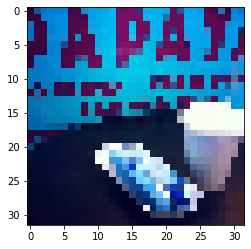

In [ ]:
plt.imshow(x_train_seefood[0])

In [ ]:
n_samp = 100 #100

cifar10 = tf.keras.datasets.cifar10 #32x32
mnist = tf.keras.datasets.mnist # 28x28

(x_train_small_mnist, y_train_small_mnist), _ = generate_dataset(n_samp, 1, mnist)
(x_train_small_cifar10, y_train_small_cifar10), _ = generate_dataset(n_samp, 1, cifar10)

170500096/170498071 [==============================] - 11s 0us/step


In [ ]:
#binary classification dataset
(x_train_small_seefood, y_train_small_seefood), _ = sampling_dataset(((x_train_seefood, y_train_seefood), (None, None)), n_samp, 1)
#(x_train_small_inria, y_train_small_inria), _ = sampling_dataset(((x_train_inria, y_train_inria), (None, None)), n_samp, 1)

In [ ]:
GSC_scores = []
input_dim = []
est_caps = []
ds = []

#config for CumulativeGradientEstimator
M_sample = 200 #default -> 250, k_nearest = 10
k_nearest = 10
isomap = None

config_cifar10 = {"ds_name":"cifar10", "embd":"vgg", "tsne":False}
config_mnist = {"ds_name":"mnist", "embd":"vgg", "tsne":False}
config_seefood = {"ds_name":"seefood", "embd":"vgg", "tsne":False}
config_inria = {"ds_name":"inria", "embd":"vgg", "tsne":False}

In [ ]:
path_circle = pjoin(DATASET_ROOT, "circle_100_35dB.csv")
path_spiral = pjoin(DATASET_ROOT, "spiral_100_35dB.csv")
path_gauss = pjoin(DATASET_ROOT, "gauss_100_35dB.csv")
path_xor = pjoin(DATASET_ROOT, "xor_100_35dB.csv")
path_moon = pjoin(DATASET_ROOT, "moon_100.csv")

config_circle = {"ds_name":"circle", "embd":"vgg", "tsne":False}
config_spiral = {"ds_name": "spiral", "embd":"vgg", "tsne":False}
config_gauss = {"ds_name": "gauss", "embd":"vgg", "tsne":False}
config_xor = {"ds_name": "xor", "embd":"vgg", "tsne":False}
config_moon = {"ds_name": "moon", "embd":"vgg", "tsne":False}

In [ ]:
x_train_circle, y_train_circle , _ = read_dataset(path_circle)
x_train_spiral, y_train_spiral , _ = read_dataset(path_spiral)
x_train_gauss, y_train_gauss, _ = read_dataset(path_gauss)
x_train_xor, y_train_xor, _ = read_dataset(path_xor)

In [ ]:
x_train_moon, y_train_moon, _ = read_dataset(path_moon)

## Calculate Cummax

In [ ]:
def cummax(config, x_train_small, y_train_small, M_sample, k_nearest, isomap, flag = True):
  if flag:
    data, ds_name, n_class, pca_params, target = get_data(config, x_train_small, y_train_small)
    estimator = CumulativeGradientEstimator(M_sample, k_nearest, isomap)
    estimator.fit(data, target)
    gsc = get_cummax(estimator.evals)
    print("----------------" + config["ds_name"] + "----------------------")
    print("mu, ub - mu, cumsums: " + str(gsc))
    print("---------------------------------------------------------------")
    return config["ds_name"], gsc[0]
  else:
    data, target = preprocessing(x_train_small, y_train_small)
    estimator = CumulativeGradientEstimator(M_sample, k_nearest, isomap)
    estimator.fit(data, target)
    gsc = get_cummax(estimator.evals)
    print("----------------" + config["ds_name"] + "----------------------")
    print("mu, ub - mu, cumsums: " + str(gsc))
    print("---------------------------------------------------------------")
    return config["ds_name"], gsc[0]

In [ ]:
#MNIST
ds_name, gsc = cummax(config_mnist, x_train_small_mnist, y_train_small_mnist, M_sample, k_nearest, isomap)
GSC_scores.append(gsc)
ds.append(ds_name)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

80142336/80134624 [==============================] - 6s 0us/step

1000/1000 [==============================] - 621s 621ms/step


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)


class_samples: [n_class, M, n_features], the M samples per class...(10, 100, 512)
----------------mnist----------------------
mu, ub - mu, cumsums: (0.42775047490164325, nan, array([0.42775047]))
---------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
#CIFAR 10
ds_name, gsc = cummax(config_cifar10, x_train_small_cifar10, y_train_small_cifar10, M_sample, k_nearest, isomap)
GSC_scores.append(gsc)
ds.append(ds_name)

1000/1000 [==============================] - 622s 622ms/step


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)


class_samples: [n_class, M, n_features], the M samples per class...(10, 100, 512)


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:42: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:42: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


----------------cifar10----------------------
mu, ub - mu, cumsums: (1.3961096948172225, nan, array([1.39610969]))
---------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
#SEEFOOD
ds_name, gsc = cummax(config_seefood, x_train_small_seefood, y_train_small_seefood, M_sample, 2, isomap)
GSC_scores.append(gsc)
ds.append(ds_name)

200/200 [==============================] - 128s 638ms/step
class_samples: [n_class, M, n_features], the M samples per class...(2, 100, 512)
----------------seefood----------------------
mu, ub - mu, cumsums: (0.6599999999999999, nan, array([0.66]))
---------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (200). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# INRIA
# ds_name, gsc = cummax(config_inria, x_train_small_inria, y_train_small_inria, M_sample, 2, isomap)
# GSC_scores.append(gsc)
# ds.append(ds_name)

In [ ]:
#2D Classification problems
ds_name, gsc = cummax(config_circle, x_train_circle, y_train_circle, 50, 2, isomap, False)
GSC_scores.append(gsc)
ds.append(ds_name)

ds_name, gsc = cummax(config_spiral, x_train_spiral, y_train_spiral, 50, 2, isomap, False)
GSC_scores.append(gsc)
ds.append(ds_name)

ds_name, gsc = cummax(config_gauss, x_train_gauss, y_train_gauss, 50, 2, isomap, False)
GSC_scores.append(gsc)
ds.append(ds_name)

ds_name, gsc = cummax(config_xor, x_train_xor, y_train_xor, 50, 2, isomap, False)
GSC_scores.append(gsc)
ds.append(ds_name)

NameError: ignored

In [ ]:
ds_name, gsc = cummax(config_moon, x_train_moon, y_train_moon, 50, 2, isomap, False)
GSC_scores.append(gsc)
ds.append(ds_name)
print(gsc)

class_samples: [n_class, M, n_features], the M samples per class...(2, 50, 2)
----------------moon----------------------
mu, ub - mu, cumsums: (0.0, nan, array([0.]))
---------------------------------------------------------------
0.0


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Heuristic Method 
"A Practical Approach to Sizing Neural Networks" by
Gerald Friedland, Alfredo Metere, Mario Michael Krell

In [ ]:
def csv_cap_est(path, ds_name):
  energies=[]
  capacity=0
  rounding=-1
  numpoints=0
  numrows=0

  with open(path,'rt') as csvfile:
    csvreader = csv.reader(csvfile)       
    for row in csvreader:
      numpoints=numpoints+1
      result = 0
      numrows = len(row[:-1])
      for elem in row[:-1]:
        result = result + float(elem) 
      c = row[-1]
      if (rounding!=-1):
        result=int(result*math.pow(10,rounding))/math.pow(10,rounding)
      energies=energies+[(result, c)]
    sortedenergies=sorted(energies, key=lambda x: x[0])
    curclass=sortedenergies[0][1]
    changes=0

    for item in sortedenergies:
      if (item[1]!=curclass):
        changes=changes+1
        curclass=item[1]

    clusters=changes+1
    mincuts=math.ceil(math.log(clusters)/math.log(2))
    capacity=mincuts*numrows
    max_cap = (changes*(numrows+1))+changes
    exp_cap = int(math.ceil(capacity))
    return max_cap, exp_cap, ds_name, numrows

# path_imgNet = pjoin(DATASET_ROOT, "imagenet2000.csv")
# a, b, c, d = csv_cap_est(path_imgNet, "imageNet2000")
# print(a, b, d, c)

In [ ]:
def img_cap_est(X, Y, shape, ds_name):
  energies=[]
  capacity=0
  rounding=-1
  numpoints=0
  numrows = 1

  for d in shape:
    numrows *= d

  for img, label in zip(X, Y):
    numpoints=numpoints+1
    result = 0
    result = np.sum([img.flatten() for features in img])
    if (rounding!=-1):
      result=int(result*math.pow(10,rounding))/math.pow(10,rounding)
    energies=energies+[(result, label)]   
  
  sortedenergies=sorted(energies, key=lambda x: x[0]) #number of different class labels (相邻) based on L1 norm calculation
  curclass=sortedenergies[0][1] 
  changes=0

  for item in sortedenergies:
    if (item[1]!=curclass):
      changes=changes+1
      curclass=item[1]

  clusters=changes+1
  mincuts=math.ceil(math.log(clusters)/math.log(2))
  capacity=mincuts*numrows
  max_cap = (changes*(numrows+1))+changes
  exp_cap = int(math.ceil(capacity))
  return max_cap, exp_cap, ds_name, numrows

## Calculation dataset capacity using the heuristic method

In [ ]:
#100 for each class(10 classes), totally 500 images
max_cap, exp_cap, ds_name, d = img_cap_est(x_train_small_mnist, y_train_small_mnist, (28,28), "mnist")
input_dim.append(d)
est_caps.append(exp_cap)
print("-------------- Multiple Classes --------------")
print("----------------- MNIST ----------------------")
print("The input dimensionality: ", d)
print("Max capacity need: ", max_cap, "bits")
print("Estimated capacity need: ", np.round(exp_cap,3),"bits")
print("--------------------------------------------")
print()

max_cap, exp_cap, ds_name, d = img_cap_est(x_train_small_cifar10, y_train_small_cifar10, (32,32,3), "cifar10")
input_dim.append(d)
est_caps.append(exp_cap)
print("----------------- CIFAR10 ---------------------")
print("The input dimensionality: ", d)
print("Max capacity need: ", max_cap, "bits")
print("Estimated capacity need: ", np.round(exp_cap,3),"bits")
print("--------------------------------------------")
print()

#binary classification
max_cap, exp_cap, ds_name, d = img_cap_est(x_train_small_seefood, y_train_small_seefood, (32,32,3), "seefood")
input_dim.append(d)
est_caps.append(exp_cap)
print("-------------- Binary Classes --------------")
print("----------------- SEEFOOD ------------------")
print("The input dimensionality: ", d)
print("Max capacity need: ", max_cap, "bits")
print("Estimated capacity need: ", np.round(exp_cap,3),"bits")
print("--------------------------------------------")
print()

# max_cap, exp_cap, ds_name, d = img_cap_est(x_train_small_inria, y_train_small_inria, (32,32,3), "inria")
# input_dim.append(d)
# est_caps.append(exp_cap)
# print("----------------- INRIA ---------------------")
# print("The input dimensionality: ", d)
# print("Max capacity need: ", max_cap, "bits")
# print("Estimated capacity need: ", np.round(exp_cap,3),"bits")
# print("--------------------------------------------")
# print()


-------------- Multiple Classes --------------
----------------- MNIST ----------------------
The input dimensionality:  784
Max capacity need:  659454 bits
Estimated capacity need:  7840 bits
--------------------------------------------

----------------- CIFAR10 ---------------------
The input dimensionality:  3072
Max capacity need:  2745082 bits
Estimated capacity need:  30720 bits
--------------------------------------------

-------------- Binary Classes --------------
----------------- SEEFOOD ------------------
The input dimensionality:  3072
Max capacity need:  307400 bits
Estimated capacity need:  21504 bits
--------------------------------------------



In [ ]:
max_cap, exp_cap, ds_name, d = csv_cap_est(path_circle, "circle_100")
input_dim.append(d)
est_caps.append(exp_cap)
print("----------------- CIRCLE ------------------")
print("The input dimensionality: ", d)
print("Max capacity need: ", max_cap, "bits")
print("Estimated capacity need: ", np.round(exp_cap,3),"bits")
print("--------------------------------------------")
print()

max_cap, exp_cap, ds_name, d = csv_cap_est(path_spiral, "spiral_100")
input_dim.append(d)
est_caps.append(exp_cap)
print("----------------- SPIRAL ------------------")
print("The input dimensionality: ", d)
print("Max capacity need: ", max_cap, "bits")
print("Estimated capacity need: ", np.round(exp_cap,3),"bits")
print("--------------------------------------------")
print()

max_cap, exp_cap, ds_name, d = csv_cap_est(path_gauss, "gauss_100")
input_dim.append(d)
est_caps.append(exp_cap)
print("----------------- GAUSS ------------------")
print("The input dimensionality: ", d)
print("Max capacity need: ", max_cap, "bits")
print("Estimated capacity need: ", np.round(exp_cap,3),"bits")
print("--------------------------------------------")
print()

max_cap, exp_cap, ds_name, d = csv_cap_est(path_xor, "xor_100")
input_dim.append(d)
est_caps.append(exp_cap)
print("----------------- XOR ------------------")
print("The input dimensionality: ", d)
print("Max capacity need: ", max_cap, "bits")
print("Estimated capacity need: ", np.round(exp_cap,3),"bits")
print("--------------------------------------------")
print()

----------------- CIRCLE ------------------
The input dimensionality:  2
Max capacity need:  120 bits
Estimated capacity need:  10 bits
--------------------------------------------

----------------- SPIRAL ------------------
The input dimensionality:  2
Max capacity need:  156 bits
Estimated capacity need:  12 bits
--------------------------------------------

----------------- GAUSS ------------------
The input dimensionality:  2
Max capacity need:  4 bits
Estimated capacity need:  2 bits
--------------------------------------------

----------------- XOR ------------------
The input dimensionality:  2
Max capacity need:  104 bits
Estimated capacity need:  10 bits
--------------------------------------------



In [ ]:
max_cap, exp_cap, ds_name, d = csv_cap_est(path_moon, "moon")
input_dim.append(d)
est_caps.append(exp_cap)
print("----------------- MOON ------------------")
print("The input dimensionality: ", d)
print("Max capacity need: ", max_cap, "bits")
print("Estimated capacity need: ", np.round(exp_cap,3),"bits")
print("--------------------------------------------")


----------------- MOON ------------------
The input dimensionality:  2
Max capacity need:  124 bits
Estimated capacity need:  10 bits
--------------------------------------------


# Final Results

In [ ]:
d = {"Input Dimension": input_dim, "Dataset": ds, "GSC Scores": GSC_scores, "Expected capcacity": est_caps}
df = pd.DataFrame(data = d)
df.set_index("Dataset").sort_values(by = "GSC Scores", ascending = False)

,Input Dimension,GSC Scores,Expected capcacity
Dataset,,,
cifar10,3072,1.396110,30720
seefood,3072,0.660000,21504
spiral,2,0.431186,12
mnist,784,0.427750,7840
xor,2,0.006088,10
circle,2,0.000000,10
gauss,2,0.000000,2
moon,2,0.000000,10


# Graph

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline

def graph(X, y, title):
  blue = y == 0
  orange = y == 1
  fig, ax = plt.subplots(figsize = (10, 8))
  # ax.set_aspect(1.0)
  ax.scatter(X[blue, 0], X[blue, 1], c="#377eb8")
  ax.scatter(X[orange, 0], X[orange, 1], c="#ff7f00")
  ax.xaxis.set_major_formatter(NullFormatter())
  ax.yaxis.set_major_formatter(NullFormatter())
  ax.set_xlabel('feature_1')
  ax.set_ylabel('feature_2')
  ax.set_title(title)
  plt.show()

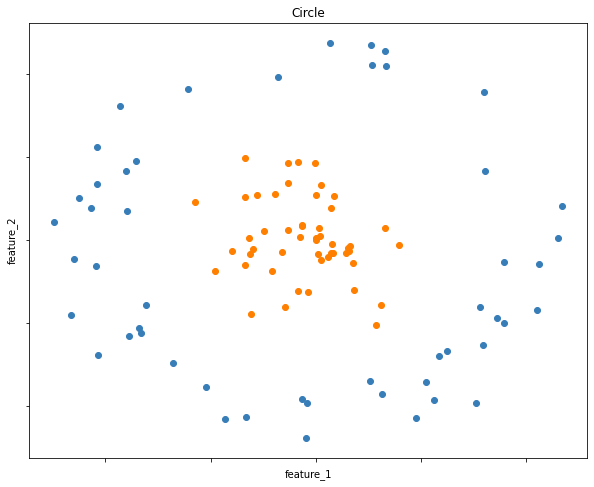

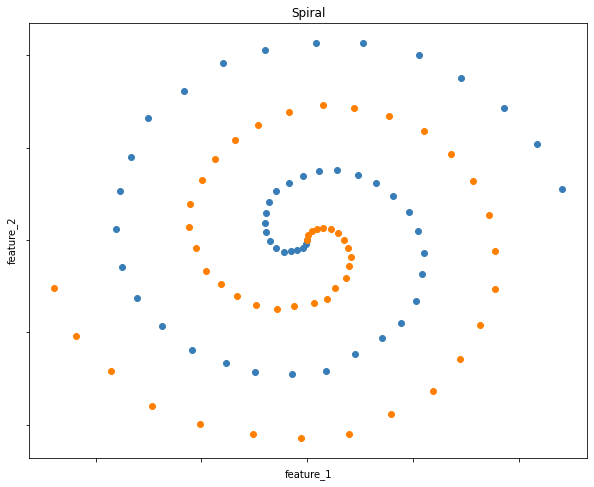

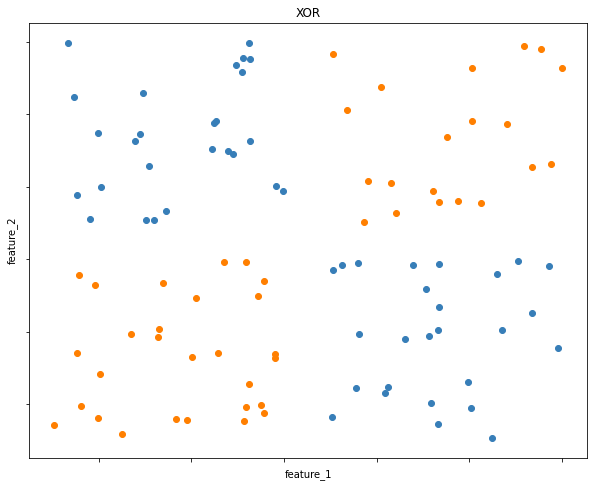

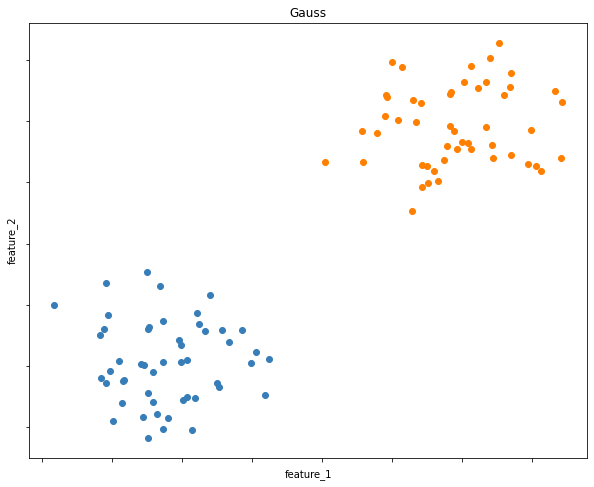

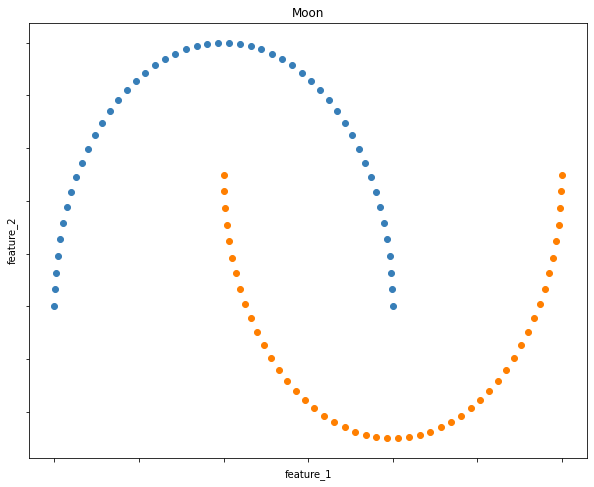

In [ ]:
graph(x_train_circle, y_train_circle, "Circle")
graph(x_train_spiral, y_train_spiral, "Spiral")
graph(x_train_xor, y_train_xor, "XOR")
graph(x_train_gauss, y_train_gauss, "Gauss")
graph(x_train_moon, y_train_moon, "Moon")

# Eigenvalues
There are ten eigenvalue for the cifar-10 due to its total classes is 10. 
The more entangled the classes are, the larger the eigenvalues are.
--> The higher the value is, it takes more effort to classify the class among other classes(more difficult task)

In [ ]:
print("Eigenvalues of CIFAR-10")
print(estimator_cifar10.evals)

In [ ]:
print("Eigenvalues of Spiral")
print(estimator_spiral.evals)

In [ ]:
print("Eigenvalues of Circle")
print(estimator_circle.evals)

Paper: "How Complex is your classification problem? A survey on measuring classification complexity"
--> This paper surveys and analyzes measures which can be extracted from the training datasets in order to characterize the complexity of the respective classification problems.


Characteristics extracted from the trainning datasets of classification problems is very crucial in determining the generalization ability of a neural network.

Measures of classification complexity can be used to estimate the difficulty in separating the data points into their expected classes.

According to Ho and Basu [2002], the complexity of a classification problem can be attributed to a combination of three main factors: 
(i) the ambiguity of the classes; The ambiguity of the classes is present in scenarios in which the classes can not be distinguished using the data provided, regardless of the classification algorithm employed. i.e poorly defined concepts & the use of non-discriminative data features.

(ii) the sparsity and dimensionality of the data; 

(iii) the complexity of the boundary separating the classes.


The complexity of classification boundary is related to the size of the smallest description needed to represent the classes and is native of the problem itself [Macià, 2011]. Using the Kolmogorov complexity concept [Ming and Vitanyi, 1993], the complexity of a classification problem can be measured by the size of the smallest algorithm which is able to describe the relationships between the data [Ling and Abu-Mostafa, 2006].



# Generate Dataset
*make_circles* and *make_moons* generate 2d binary classification datasets, including optional Gaussian noise.

*make_circles* produces Gaussian data with a spherical decision boundary for binary classification, while *make_moons* produces two interleaving half circles.

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.datasets import make_moons, make_blobs, make_circles
import math

In [ ]:
def generateDatasetMoons(n_samples, noise):
  X, y = make_moons(n_samples, noise)
  df = pd.DataFrame(X, columns=["feature_1", "feature_2"])
  df["label"] = y
  return X, y

def generateDatasetCircle(n_samples, factor, noise):
  X, y = make_circles(n_samples, factor, noise) 
  df = pd.DataFrame(X, columns=["feature_1", "feature_2"])
  df["label"] = y
  return X, y

In [ ]:
n_samples = 500
factor = 0.5
noise = 0.05
X_circle, y_circle = generateDatasetCircle(n_samples=n_samples, factor=.8, noise=.05)
X_moons, y_moons = generateDatasetMoons(n_samples, noise)

def graph(X,y):
  red = y == 0
  green = y == 1
  fig, ax = plt.subplots(figsize = (10, 8))
  ax.scatter(X[red, 0], X[red, 1], c="#377eb8")
  ax.scatter(X[green, 0], X[green, 1], c="#ff7f00")
  ax.xaxis.set_major_formatter(NullFormatter())
  ax.yaxis.set_major_formatter(NullFormatter())
  ax.set_xlabel('feature_1')
  ax.set_ylabel('feature_2')
  plt.show()

In [ ]:
import random
def dSNR(x):
  return 1 / math.pow(10, x / 10)

def randUniform(a, b):
	return random.random() * (b - a) + a

def normalRandom(mean = 0, variance = 1): 
  v1 = 0
  v2 = 0
  s = 0
  while True:
    v1 = 2 * random.random() - 1
    v2 = 2 * random.random() - 1
    s = v1 * v1 + v2 * v2
    if s <= 1:
      break
  result = math.sqrt(-2 * math.log(s) / s) * v1
  return mean + math.sqrt(variance) * result

def classifyXORData(n_samples, noise):
  dNoise = dSNR(noise)
  stdSignal = 5
  X = []
  y = []
  for i in range(n_samples):
    x1 = randUniform(-stdSignal, stdSignal)
    padding = 0.3
    if x1 > 0:
      x1 += padding
    else:
      x1 -= padding

    x2 = randUniform(-stdSignal, stdSignal);
    if x2 > 0:
      x2 += padding
    else:
      x2 -= padding

    varianceSignal = stdSignal * stdSignal
    noiseX = normalRandom(0, varianceSignal * dNoise)
    noiseY = normalRandom(0, varianceSignal * dNoise)
    if (x1 + noiseX) * (x2 + noiseY) >= 0:
      y.append(1)
    else:
      y.append(0)

    X.append([noiseX, noiseY])
  return X,y

In [ ]:
X_Xor, y_Xor = classifyXORData(n_samples, 0.05)

In [ ]:
#graph(np.asarray(X_Xor), np.asarray(y_Xor))

In [ ]:
#graph(X_circle,y_circle)

In [ ]:
graph(X_moons, y_moons)